In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import os
# Set the working directory to where your files are
os.chdir('/content/drive/My Drive/Colab Notebooks/NVR')


In [6]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

# load the datasets
customer_survey = pd.read_excel("CustomerSurvey.xlsx")
post_settlement = pd.read_excel("PostSettlement.xlsx")
quality_nho = pd.read_excel("QualityNHO.xlsx")
warranty_spend = pd.read_excel("WarrantySpend.xlsx")


In [7]:
# -----------------------------
# Step 1: Data Preprocessing
# -----------------------------
# convert date fields to datetime (handling '00:00:00' placeholders)
post_settlement['Actual Settlement Date'] = pd.to_datetime(post_settlement['Actual Settlement Date'], errors='coerce')
post_settlement['Ticket Date'] = pd.to_datetime(post_settlement['Ticket Date'], errors='coerce')
warranty_spend['Batch Date'] = pd.to_datetime(warranty_spend['Batch Date'], errors='coerce')
quality_nho['Actual Settlement Date'] = pd.to_datetime(quality_nho['Actual Settlement Date'], errors='coerce')

# Ensure 'Vendor Number' is consistently string type for OneHotEncoding
post_settlement['Vendor Number'] = post_settlement['Vendor Number'].astype(str)
warranty_spend['Vendor Number'] = warranty_spend['Vendor Number'].astype(str)

In [8]:
# -----------------------------
# Step 2: Data Merging
# -----------------------------

# merge post settlement and warranty spend on DCLU Key, Vendor Number, and Community Code
merged_tickets_spend = pd.merge(
    post_settlement,
    warranty_spend,
    on=['DCLU Key', 'Vendor Number', 'Community Code'],
    how='outer',
    suffixes=('_ticket', '_spend')
)


In [9]:
# -----------------------------
# Step 3: Aggregation (Revised)
# -----------------------------

# aggregate ticket counts from post_settlement
tickets_agg = post_settlement.groupby(['Product Name', 'Vendor Number', 'Community Code']).agg(
    ticket_count=pd.NamedAgg(column='Ticket Number', aggfunc='count')
).reset_index()

# aggregate spend from warranty_spend
spend_agg = warranty_spend.groupby(['Vendor Number', 'Community Code']).agg(
    total_spend=pd.NamedAgg(column='Invoice Line Amount', aggfunc='sum')
).reset_index()

# merge ticket counts and spend on Vendor Number and Community Code
agg_data = pd.merge(
    tickets_agg,
    spend_agg,
    on=['Vendor Number', 'Community Code'],
    how='left'
)

# fill missing spend with 0
agg_data['total_spend'] = agg_data['total_spend'].fillna(0)

In [10]:
# -----------------------------
# Step 4: Performance Scoring
# -----------------------------

# calculate cost per ticket (avoid division by zero)
agg_data['cost_per_ticket'] = agg_data.apply(
    lambda row: row['total_spend'] / row['ticket_count'] if row['ticket_count'] > 0 else None,
    axis=1
)

In [11]:
# -----------------------------
# Step 5: Anomaly Detection
# -----------------------------

# calculate z-scores for ticket_count and cost_per_ticket
agg_data['ticket_zscore'] = (agg_data['ticket_count'] - agg_data['ticket_count'].mean()) / agg_data['ticket_count'].std()
agg_data['cost_zscore'] = (agg_data['cost_per_ticket'] - agg_data['cost_per_ticket'].mean()) / agg_data['cost_per_ticket'].std()

# flag anomalies (z-score > 2 or < -2)
agg_data['anomaly_ticket'] = agg_data['ticket_zscore'].abs() > 2
agg_data['anomaly_cost'] = agg_data['cost_zscore'].abs() > 2

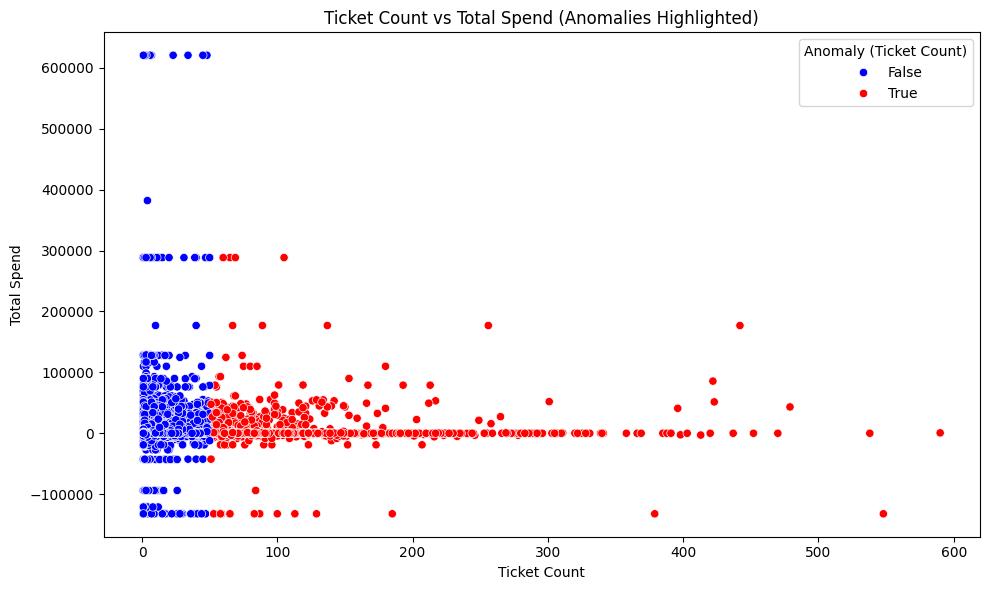

In [12]:
# -----------------------------
# Step 6: Visualization
# -----------------------------

# scatter plot for ticket count vs total spend
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=agg_data,
    x='ticket_count',
    y='total_spend',
    hue='anomaly_ticket',
    palette={True: 'red', False: 'blue'}
)
plt.title('Ticket Count vs Total Spend (Anomalies Highlighted)')
plt.xlabel('Ticket Count')
plt.ylabel('Total Spend')
plt.legend(title='Anomaly (Ticket Count)')
plt.tight_layout()
plt.show()


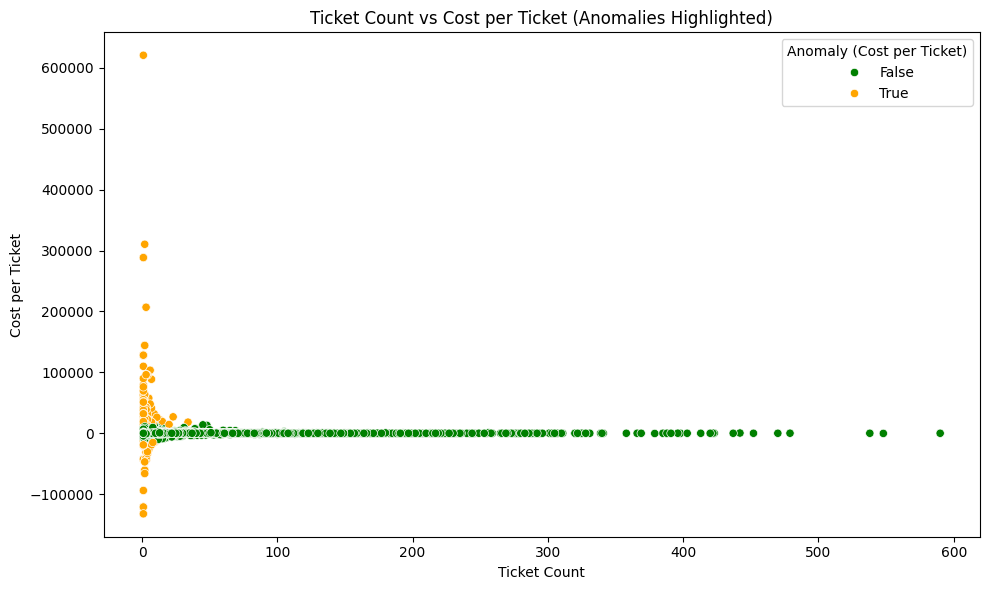

In [13]:
# scatter plot for ticket count vs cost per ticket
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=agg_data,
    x='ticket_count',
    y='cost_per_ticket',
    hue='anomaly_cost',
    palette={True: 'orange', False: 'green'}
)
plt.title('Ticket Count vs Cost per Ticket (Anomalies Highlighted)')
plt.xlabel('Ticket Count')
plt.ylabel('Cost per Ticket')
plt.legend(title='Anomaly (Cost per Ticket)')
plt.tight_layout()
plt.show()

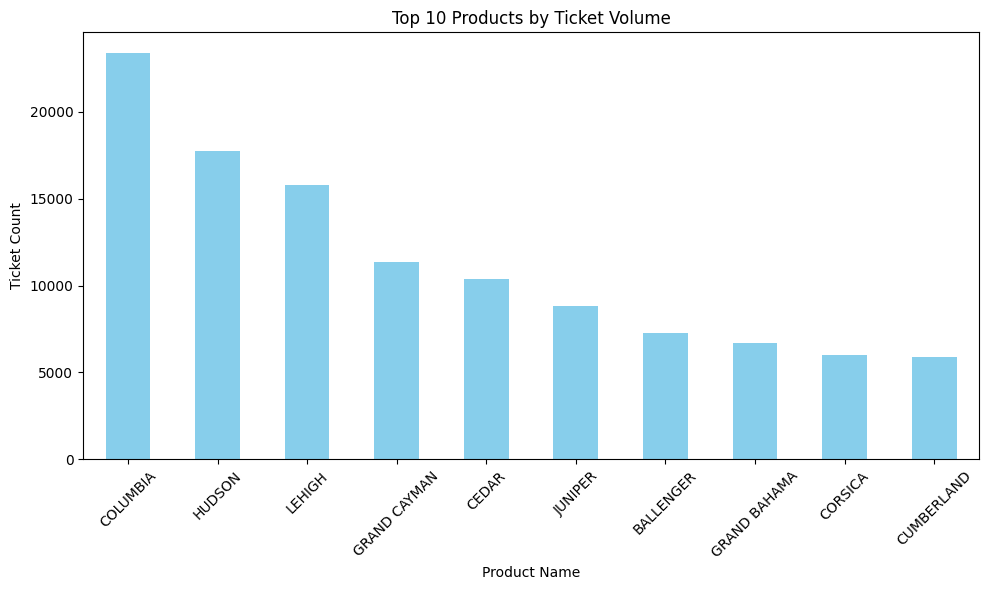

In [14]:
# -----------------------------
# Additional Visualizations
# -----------------------------

# Bar chart: Top products by ticket volume
plt.figure(figsize=(10, 6))
top_products = agg_data.groupby('Product Name')['ticket_count'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='bar', color='skyblue')
plt.title('Top 10 Products by Ticket Volume')
plt.xlabel('Product Name')
plt.ylabel('Ticket Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

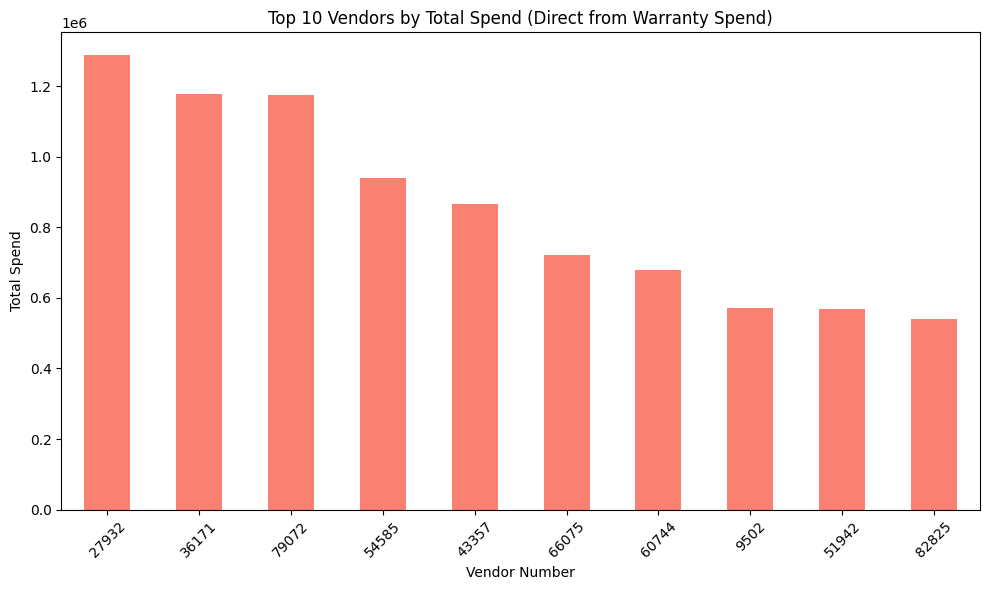

In [15]:
# Bar chart: Top vendors by total spend (from warranty_spend directly)
plt.figure(figsize=(10, 6))
top_vendors = warranty_spend.groupby('Vendor Number')['Invoice Line Amount'].sum().sort_values(ascending=False).head(10)
top_vendors.plot(kind='bar', color='salmon')
plt.title('Top 10 Vendors by Total Spend (Direct from Warranty Spend)')
plt.xlabel('Vendor Number')
plt.ylabel('Total Spend')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


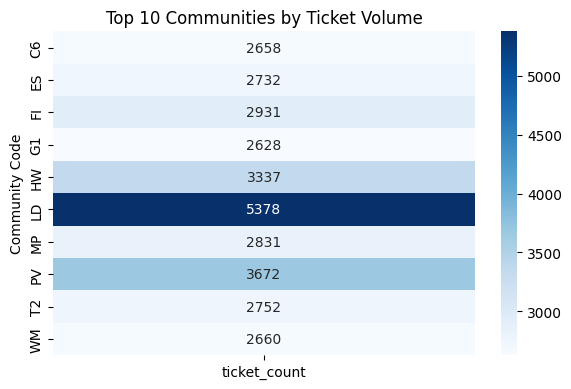

In [16]:
# Heatmap: Ticket volume per community (top 10)
top_communities_tickets = agg_data.groupby('Community Code')['ticket_count'].sum().sort_values(ascending=False).head(10).reset_index()
plt.figure(figsize=(6, 4))
sns.heatmap(top_communities_tickets.pivot_table(index='Community Code', values='ticket_count'), annot=True, fmt='.0f', cmap='Blues')
plt.title('Top 10 Communities by Ticket Volume')
plt.tight_layout()
plt.show()

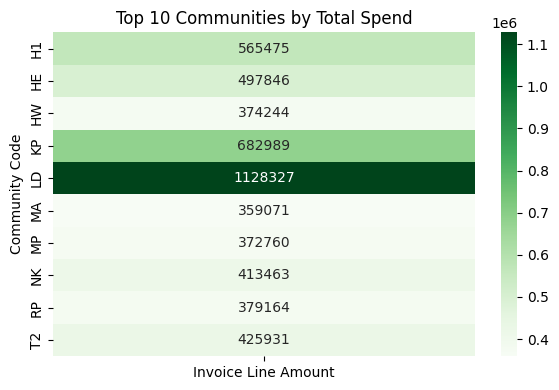

In [17]:
# Heatmap: Spend per community (top 10)
top_communities_spend = warranty_spend.groupby('Community Code')['Invoice Line Amount'].sum().sort_values(ascending=False).head(10).reset_index()
plt.figure(figsize=(6, 4))
sns.heatmap(top_communities_spend.pivot_table(index='Community Code', values='Invoice Line Amount'), annot=True, fmt='.0f', cmap='Greens')
plt.title('Top 10 Communities by Total Spend')
plt.tight_layout()
plt.show()

<ipython-input-18-5e943ae9df4c>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_products_cost = agg_data.groupby('Product Name').apply(


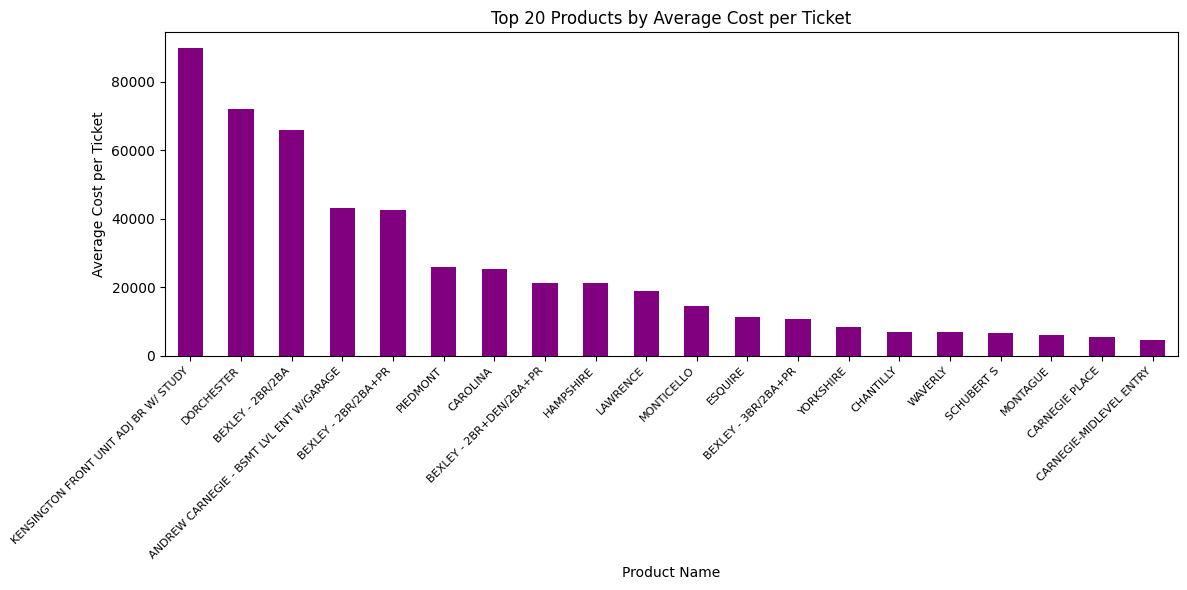

In [18]:
# Bar chart: Top 20 products by average cost per ticket (with aligned labels)
plt.figure(figsize=(12, 6))

# group by product, calculate average cost per ticket
top_products_cost = agg_data.groupby('Product Name').apply(
    lambda x: (x['total_spend'].sum() / x['ticket_count'].sum()) if x['ticket_count'].sum() > 0 else 0
).sort_values(ascending=False).head(20)

# plot
top_products_cost.plot(kind='bar', color='purple')
plt.title('Top 20 Products by Average Cost per Ticket')
plt.xlabel('Product Name')
plt.ylabel('Average Cost per Ticket')
plt.xticks(rotation=45, ha='right', fontsize=8)  # tweak alignment and font size here
plt.tight_layout()
plt.show()


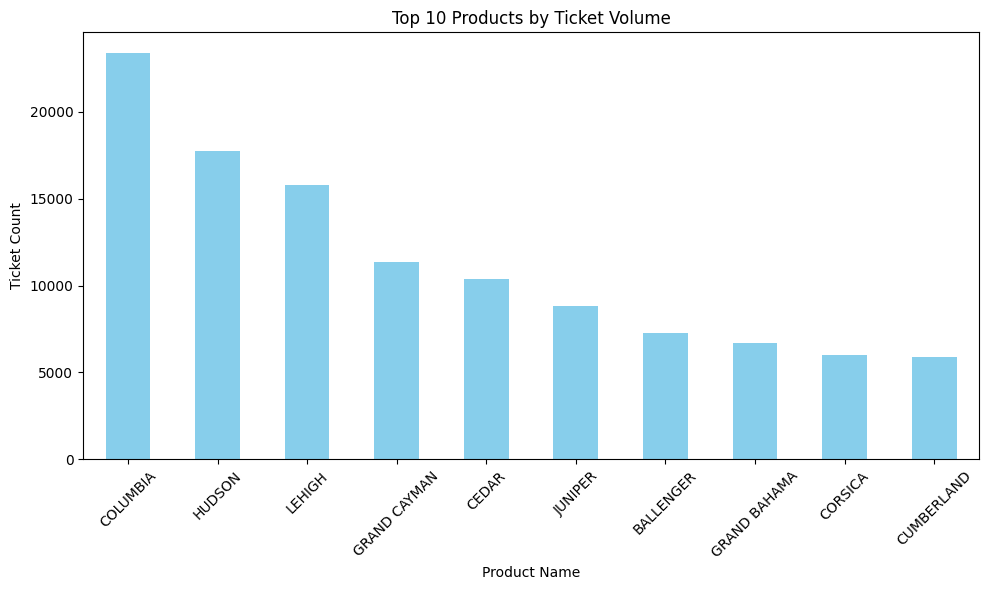

In [19]:
# Bar chart: Top products by ticket volume
plt.figure(figsize=(10, 6))
top_products = agg_data.groupby('Product Name')['ticket_count'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='bar', color='skyblue')
plt.title('Top 10 Products by Ticket Volume')
plt.xlabel('Product Name')
plt.ylabel('Ticket Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


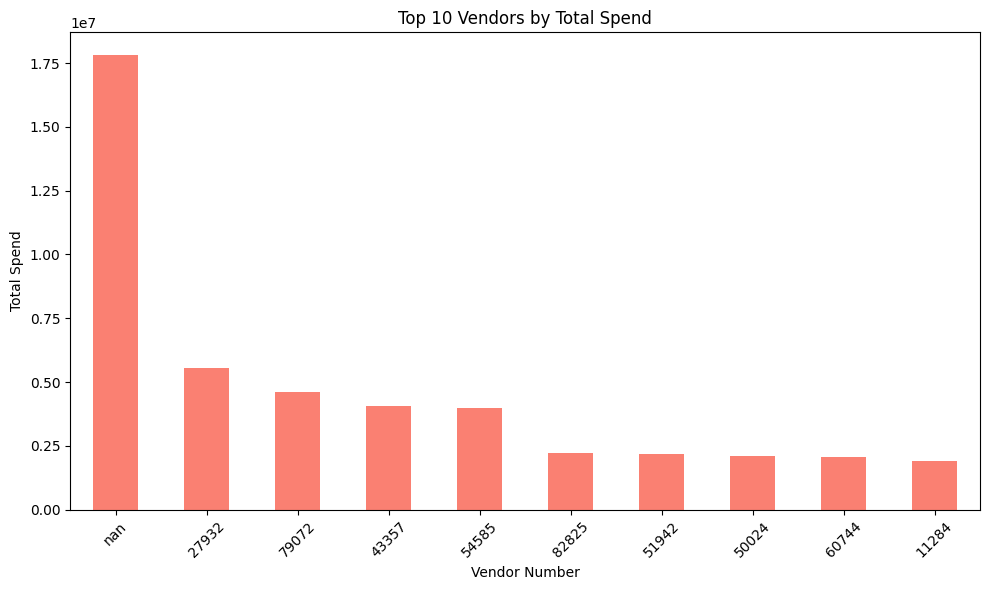

In [20]:
# Bar chart: Top vendors by total spend
plt.figure(figsize=(10, 6))
top_vendors = agg_data.groupby('Vendor Number')['total_spend'].sum().sort_values(ascending=False).head(10)
top_vendors.plot(kind='bar', color='salmon')
plt.title('Top 10 Vendors by Total Spend')
plt.xlabel('Vendor Number')
plt.ylabel('Total Spend')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


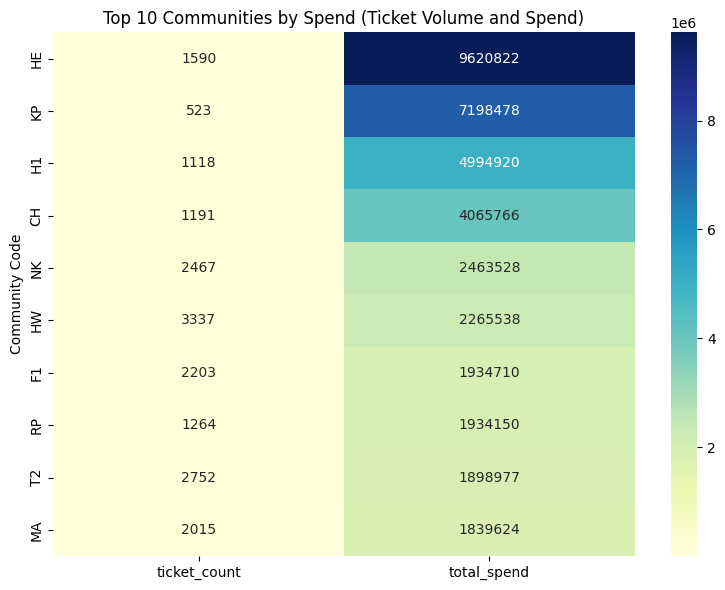

In [21]:
# Sum ticket volume and spend per community
community_pivot = agg_data.groupby('Community Code')[['ticket_count', 'total_spend']].sum()

# Sort by total spend (or ticket_count) and take top 10
top_communities = community_pivot.sort_values(by='total_spend', ascending=False).head(10)

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(top_communities, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Top 10 Communities by Spend (Ticket Volume and Spend)')
plt.tight_layout()
plt.show()


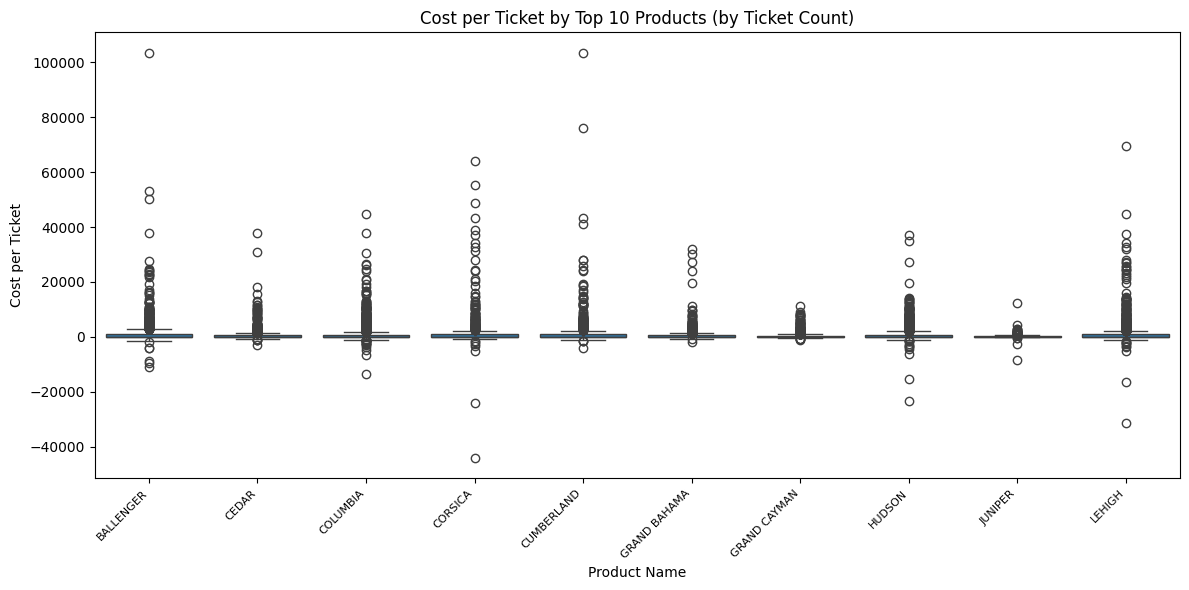

In [22]:
# Filter top 10 products by ticket count
top_products = agg_data.groupby('Product Name')['ticket_count'].sum().sort_values(ascending=False).head(10).index
filtered_data = agg_data[agg_data['Product Name'].isin(top_products)]

# Boxplot: Cost per ticket for top products
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_data, x='Product Name', y='cost_per_ticket')
plt.title('Cost per Ticket by Top 10 Products (by Ticket Count)')
plt.xlabel('Product Name')
plt.ylabel('Cost per Ticket')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()


In [23]:
# -----------------------------
# Step 7: Predictive Modeling
# -----------------------------
import joblib
# prepare features and targets
features = agg_data[['Product Name', 'Vendor Number', 'Community Code']]
target_tickets = agg_data['ticket_count']
target_spend = agg_data['total_spend']

# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
encoder = LabelEncoder()

# Create a new DataFrame for encoded features
features_encoded = pd.DataFrame(index=features.index)

# Iterate through columns and encode if they are of type 'object' (string)
for col in features.columns:
    # Ensure the column is of type object (string) before encoding
    if features[col].dtype == 'object':
        # Convert all values in the column to strings before encoding
        features_encoded[col] = encoder.fit_transform(features[col].astype(str))
    else:
        features_encoded[col] = features[col] # Keep numeric columns as they are

# split data for ticket prediction
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(features_encoded, target_tickets, test_size=0.2, random_state=42)

# split data for spend prediction
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(features_encoded, target_spend, test_size=0.2, random_state=42)

# train random forest for ticket prediction with limited depth
ticket_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
ticket_model.fit(X_train_t, y_train_t)
y_pred_t = ticket_model.predict(X_test_t)

# train random forest for spend prediction with limited depth
spend_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
spend_model.fit(X_train_s, y_train_s)
y_pred_s = spend_model.predict(X_test_s)

In [24]:
# evaluate ticket prediction
print("Ticket Prediction Metrics:")
print("MAE:", mean_absolute_error(y_test_t, y_pred_t))
print("RMSE:", np.sqrt(mean_squared_error(y_test_t, y_pred_t)))
print("R^2:", r2_score(y_test_t, y_pred_t))

Ticket Prediction Metrics:
MAE: 7.767143100186012
RMSE: 19.947812650535095
R^2: 0.15745894758208168


In [25]:
# evaluate spend prediction
print("\nSpend Prediction Metrics:")
print("MAE:", mean_absolute_error(y_test_s, y_pred_s))
print("RMSE:", np.sqrt(mean_squared_error(y_test_s, y_pred_s)))
print("R^2:", r2_score(y_test_s, y_pred_s))



Spend Prediction Metrics:
MAE: 2713.6553515151086
RMSE: 5859.32597332789
R^2: 0.8737637614462951


In [26]:
# Import the joblib library
import joblib

# 2. Save the ticket prediction model
joblib.dump(ticket_model, '/content/drive/MyDrive/Colab Notebooks/NVR/ticket_model.pkl')

# 3. Save the spend prediction model
joblib.dump(spend_model, '/content/drive/MyDrive/Colab Notebooks/NVR/spend_model.pkl')

['/content/drive/MyDrive/Colab Notebooks/NVR/spend_model.pkl']